# Описание проекта

### Задача

Подготовить прототип модели машинного обучения для «Цифры».  
Компания разрабатывает решения для эффективной работы промышленных предприятий.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.  
В нашем распоряжении данные с параметрами добычи и очистки. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

**Нам нужно:**
* Подготовить данные;
* Провести исследовательский анализ данных;
* Построить и обучить модель.


### Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.  
**1. Флотация**  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.  
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  

**2. Очистка**  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных

**Технологический процесс**  
* `Rougher feed` — исходное сырье
* `Rougher additions` (или `reagent additions`) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`
> `Xanthate` **— ксантогенат (промотер, или активатор флотации);  
`Sulphate` — сульфат (на данном производстве сульфид натрия);  
`Depressant` — депрессант (силикат натрия).  

* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота  

**Параметры этапов**  
* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

### Расчёт эффективности

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.   
Эффективность обогащения рассчитывается по формуле:

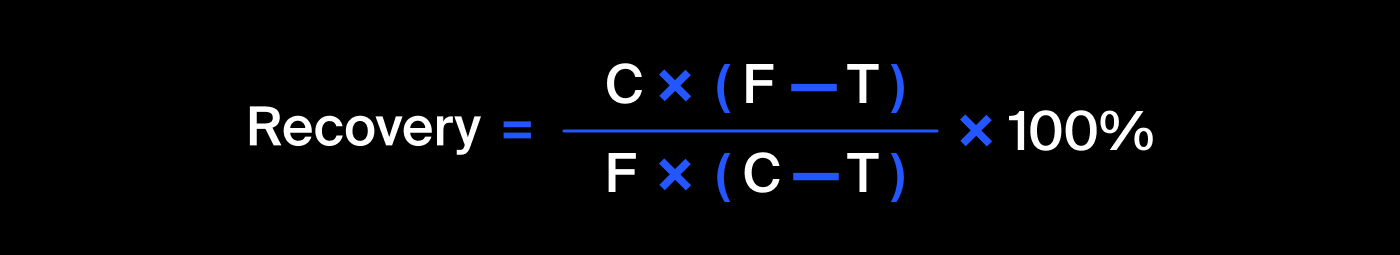


где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.  

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Важен не только финальный продукт, но и черновой концентрат.

### Метрика качества

Для решения задачи введём новую метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
Симметричная потому что она одинаково учитывает масштаб и целевого признака, и предсказания.  

**Метрика sMAPE вычисляется так:**

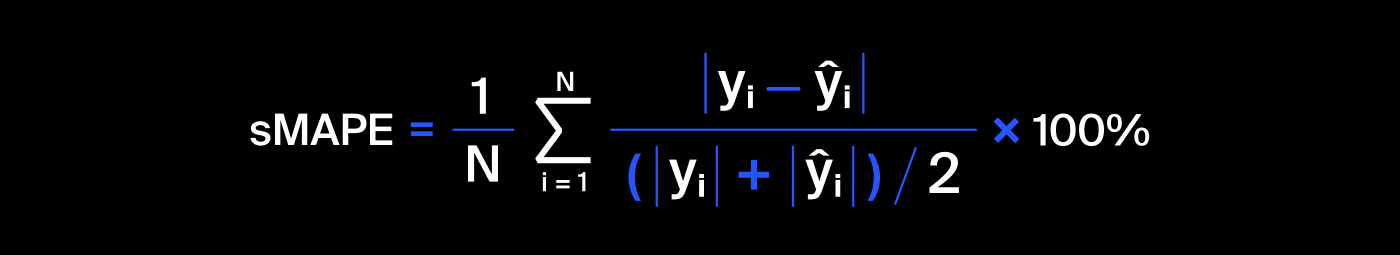

**Обозначения:**
* $y_{i}$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.  
* $y_{i}$ с крышкой - значение предсказания для объекта с порядковым номером i.
* $N$ - количество объектов в выборке. 

Нужно спрогнозировать сразу две величины:
1. эффективность обогащения чернового концентрата `rougher.output.recovery`;
2. эффективность обогащения финального концентрата `final.output.recovery`.    

Итоговая метрика складывается из двух величин:

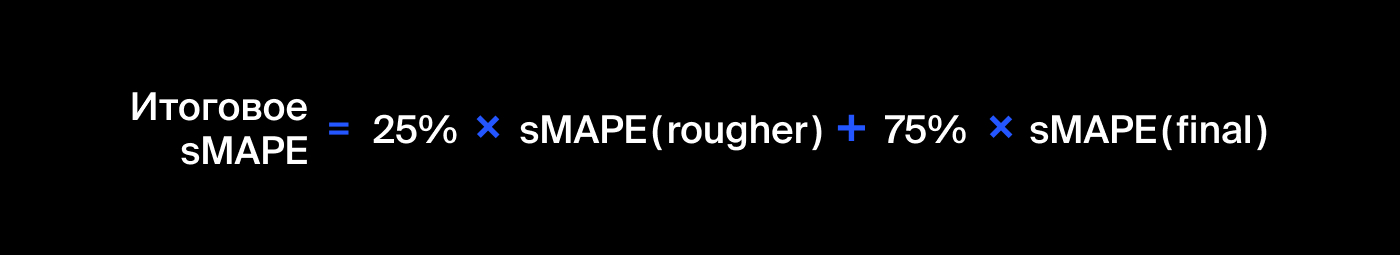

# Подготовка данных

In [ ]:
# !pip install sweetviz --quiet библиотека для отчетов

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 65.7 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.metrics import * 
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#import sweetviz as sv импортируем библиотеку для создания отчета

from tqdm import tqdm

Загрузка датасетов.

In [ ]:
try:
  data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
  !gdown --id 1WBVAUqqFt5jW0V2AzO_bXJaWed7dQmQz
  data_train = pd.read_csv('gold_recovery_train_new.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WBVAUqqFt5jW0V2AzO_bXJaWed7dQmQz
To: /content/gold_recovery_train_new.csv
100% 22.8M/22.8M [00:00<00:00, 160MB/s] 


In [ ]:
try:
  data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
  !gdown --id 109MtYha70XyRMpE1g4Z3XzKxo5JK29-1
  data_test = pd.read_csv('gold_recovery_test_new.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=109MtYha70XyRMpE1g4Z3XzKxo5JK29-1
To: /content/gold_recovery_test_new.csv
100% 5.27M/5.27M [00:00<00:00, 66.6MB/s]


In [ ]:
try:
  data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
  !gdown --id 1wtuOV3BXUvQxY5RhFgTrDDf9ABV1sByZ
  data_full = pd.read_csv('gold_recovery_full_new.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wtuOV3BXUvQxY5RhFgTrDDf9ABV1sByZ
To: /content/gold_recovery_full_new.csv
100% 31.3M/31.3M [00:00<00:00, 40.8MB/s]


Создадим отчет и посмотрим на данные.

In [ ]:
# report_0 = sv.compare([data_train, 'Обучающий набор'], [data_test, "Тестовый набор"]) создание отчета
# report_0.show_html() загрузка

                                             |          | [  0%]   00:00 -> (? left)

[Отчет](https://drive.google.com/file/d/1OJaa4MdAPUcQzt32Pm8E4ra3tXJJhnzt/view?usp=sharing)

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


**Итак,** у нас три датасета: один - это полная таблица с данными, а два другие - это общая таблица, разделенная на обучающие данные и тестовые.   
Всего у нас имеется 87 колонок, из которых одна имеет тип данных object(которая хранит дату), остальные имеют тип float.  
Записей всего 19439. В обучающем наборе 14149 и 87 колонок, в тестовом - 5290 и 53 колонки. Для обучения модели нам надо будет взять из обучающего набора те данные, которые есть в тестовом наборе.  
Дубликатов в данных нет. Есть пропуски, но не во всех колонках. В основном процент пропусков в тестовом и обучающем наборе составляет менее 1%, но есть несколько признаков с пропусками в 2-3%. Также есть колонка в обучающем наборе `secondary_cleaner.output.tail_sol` в которой 11% пропусков. Есть и нулевые значения в некоторых колонках, но их в основном не более 1%.  
Более детальная информация в отчете.

### Проверим, что эффективность обогащения рассчитана правильно

Вычислим эффективность на обучающей выборке для признака rougher.output.recovery.

По нашей формуле:  
$C = $ `rougher.output.concentrate_au`,  
$T = $ `rougher.output.tail_au`,  
$F = $ `rougher.input.feed_au`

Напишем функцию расчета эффективности.

In [ ]:
def recovery(data):
  c = data.loc[:, 'rougher.output.concentrate_au']
  f = data.loc[:, 'rougher.input.feed_au']
  t = data.loc[:, 'rougher.output.tail_au']
  return (c * (f - t)) / (f * ( c - t)) * 100

Для удобства создадим таблицу с необходимыми данными и проанализируем ее.

In [ ]:
data_0 = data_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]
data_0

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
0,19.793808,6.486150,1.170244,87.107763
1,20.050975,6.478583,1.184827,86.843261
2,19.737170,6.362222,1.162562,86.842308
3,19.320810,6.118189,1.079755,87.226430
4,19.216101,5.663707,1.012642,86.688794
...,...,...,...,...
14144,18.603550,5.335862,0.748633,89.574376
14145,18.441436,4.838619,0.771582,87.724007
14146,15.111231,4.525061,0.685059,88.890579
14147,17.834772,4.362781,0.567130,89.858126


In [ ]:
pd.options.mode.chained_assignment = None
data_0.loc[:,'recovery'] = recovery(data_0)
data_0.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,recovery
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


In [ ]:
data_0['rougher.output.recovery'].describe()

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [ ]:
data_0['recovery'].describe()

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: recovery, dtype: float64

Добавим колонку с разницей между расчитанной эффективностью и той, что дана.

In [ ]:
data_0['difference'] = data_0['rougher.output.recovery'] - data_0['recovery']

In [ ]:
data_0['difference'].describe()

count    1.414900e+04
mean     1.388544e-16
std      1.475784e-14
min     -7.105427e-14
25%     -1.421085e-14
50%      0.000000e+00
75%      1.421085e-14
max      8.526513e-14
Name: difference, dtype: float64

Найдем MAE между нашими расчётами и значением признака.

In [ ]:
mean_absolute_error(data_0['rougher.output.recovery'], data_0['recovery'])

9.73512347450521e-15

Выводы.

Рассчитанная и табличная эффективность почти не имеют различий. Среднее абсолютное отклонение равно $9*10^{-15}$, то есть мы в среднем ошибаемся на это число от табличного значения.  
Так же мы видим, что средняя эффективность равна 82.7%. 75% всех значений эффективности находятся выше 79.9%.

### Проанализируем признаки, недоступные в тестовой выборке

Создадим список тех признаков, которые недоступны в тестовой выборке.

In [ ]:
column_not_test = set(data_train.columns) - set(data_test.columns)
column_not_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Итак,** в тестовой выборке не доступны данные о концентрации веществ(золота, серебра, свинца, соли) в финальном продукте, после первичной и вторичной очистки, после флотации, также концентрация этих веществ в отвальных хвостах на тех же этапах. Так же не доступно значение эффективности.

### Проведем предобработку данных

Данные представляют собой последовательные технологические процессы, поэтому мы можем заполнить пропуски предыдущими значениями.

In [ ]:
data_train.ffill(inplace=True)
data_test.ffill(inplace=True)
data_full.ffill(inplace=True)

In [ ]:
data_train.isna().sum().value_counts()

0    87
dtype: int64

In [ ]:
data_test.isna().sum().value_counts()

0    53
dtype: int64

In [ ]:
data_full.isna().sum().value_counts()

0    87
dtype: int64

Добавим в тестовую выборку целевые показатели.

In [ ]:
data_test = data_test.merge(data_full.loc[:, ['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

In [ ]:
data_test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

# Анализ данных

###  Посмотрим изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Создадим список колонок с данными о концентрации метоллов.

In [ ]:
list_concent = []
for col in data_full.columns:
  if ('au' in col or 'pb' in col or 'ag' in col) and ('calculation' not in col) and ('tail' not in col):
    list_concent.append(col)

list_concent

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

Создадим таблицу для анализа изменения концентрации металлов.

In [ ]:
concetrate = data_full[list_concent]
concetrate

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au
0,6.055403,9.889648,42.192020,8.547551,10.389648,34.174427,6.100378,2.284912,6.486150,11.500771,7.101074,19.793808
1,6.029369,9.968944,42.701629,8.558743,10.497069,34.118526,6.161113,2.266033,6.478583,11.615865,7.278807,20.050975
2,6.055926,10.213995,42.657501,8.603505,10.354494,33.969464,6.116455,2.159622,6.362222,11.695753,7.216833,19.737170
3,6.047977,9.977019,42.689819,7.221879,8.496563,28.260743,6.043309,2.037807,6.118189,11.915047,7.175616,19.320810
4,6.148599,10.142511,42.774141,9.089428,9.986786,33.044932,6.060915,1.786875,5.663707,12.411054,7.240205,19.216101
...,...,...,...,...,...,...,...,...,...,...,...,...
19434,3.224920,11.356233,46.713954,6.559174,12.445966,32.940215,6.091855,4.617558,5.335862,11.124896,10.984003,18.603550
19435,3.195978,11.349355,46.866780,6.612376,12.623947,32.925325,6.121323,4.144989,4.838619,11.425983,10.888213,18.441436
19436,3.109998,11.434366,46.795691,7.128896,12.633558,31.856742,5.970515,4.020002,4.525061,8.523497,8.955135,15.111231
19437,3.367241,11.625587,46.408188,7.490444,12.012378,30.770892,6.048130,3.902537,4.362781,11.658799,10.655377,17.834772


Напишем функцию для построения графика "ящик с усами" для каждого этапа.

In [ ]:
def boxpl(data, stage):
  column = []
  for col in data.columns:
    if stage in col:
      column.append(col)
  data_boxplot = data[column]
  return sns.boxplot(data=data_boxplot, orient='h').set(title=stage)

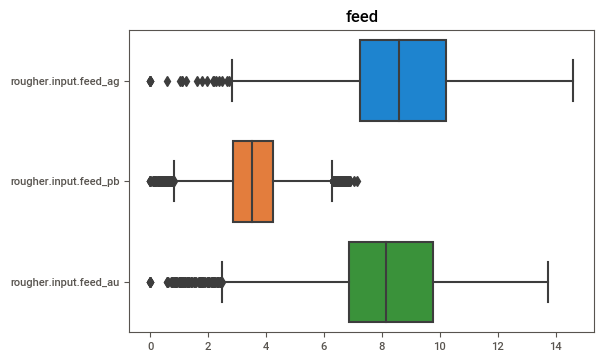

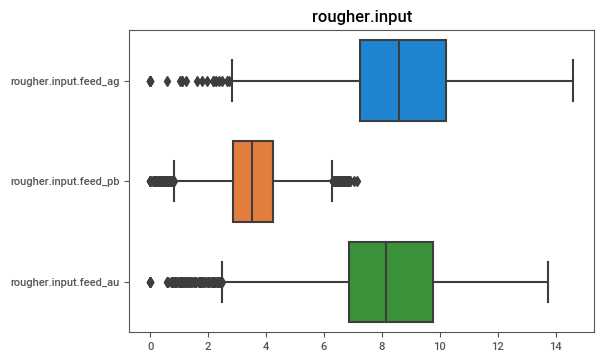

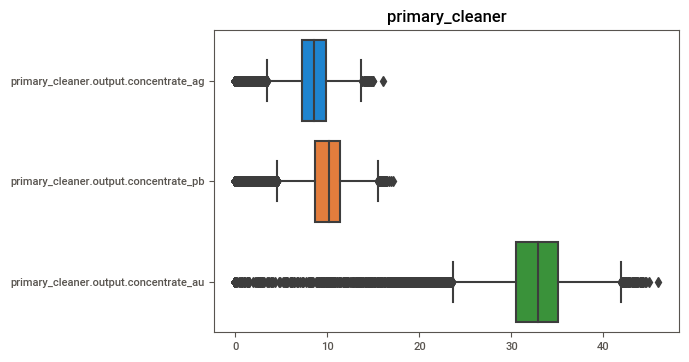

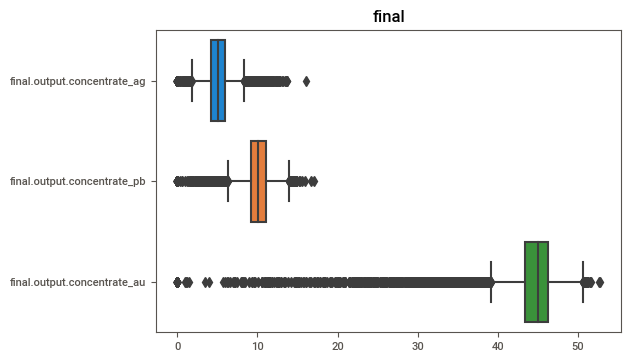

In [ ]:
boxpl(concetrate, 'feed')
plt.show()

boxpl(concetrate, 'rougher.input')
plt.show()

boxpl(concetrate, 'primary_cleaner')
plt.show()

boxpl(concetrate, 'final')
plt.show()

На начальных этапах большой разброс значений концетрации, на финалаьно этапе концентрация серебра и свинца ниже 20, включая выбросы. Золото на финальном этапе имеет концентрацию от 40 до 50, но есть много выбросов.

Напишем функцию для построения графика концентрации каждого металла на разных этапах.

In [ ]:
def hist_data(data, ore):
    column = []
    for col in data.columns:
        if ore in col:
            column.append(col)
    data_hist = data[column]
    return data_hist

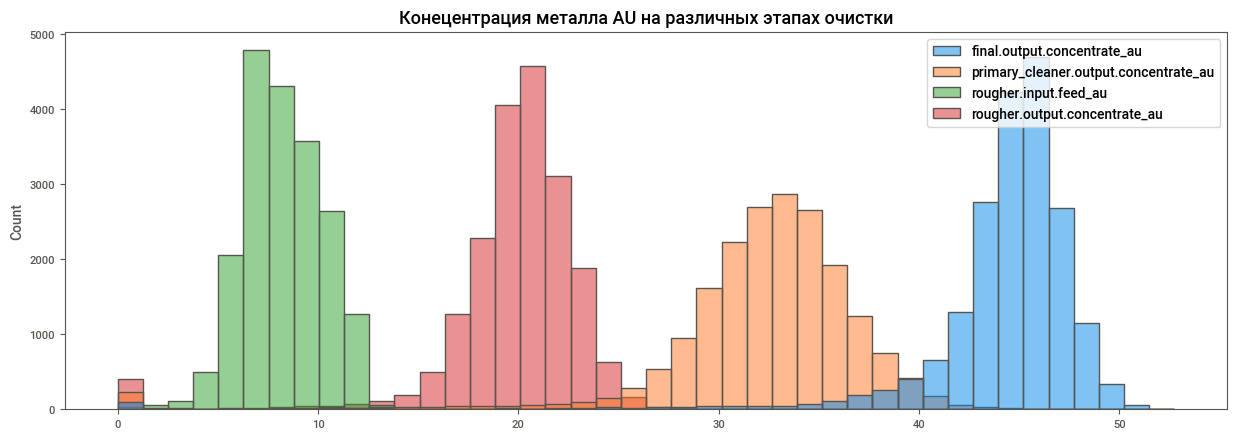

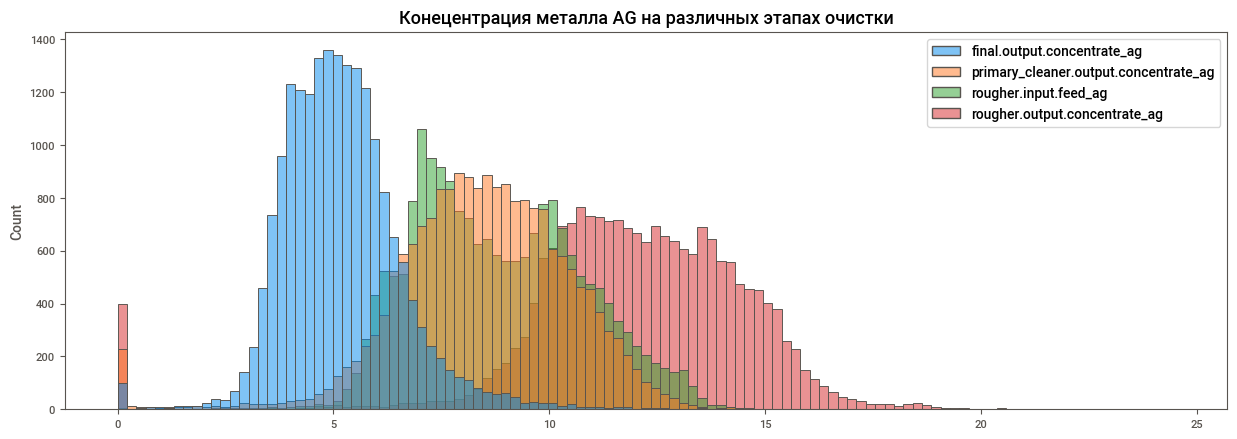

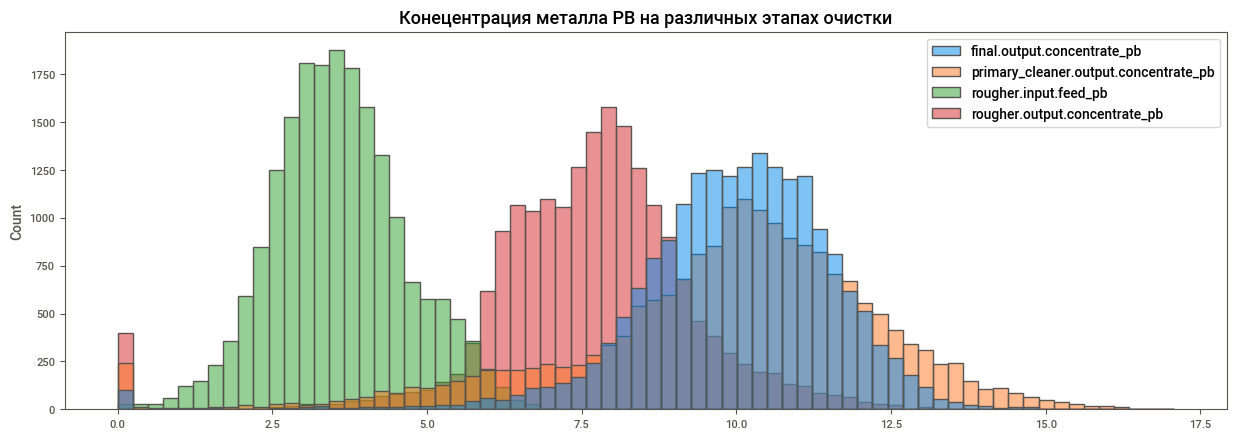

In [ ]:
for metal in ['au', 'ag', 'pb']:
  plt.figure(figsize=[15, 5])
  plt.title(
        f'Конецентрация металла {metal.upper()} на различных этапах очистки', fontsize=13)
  sns.histplot(hist_data(concetrate, metal))

**Выводы:**

На каждом графике `boxplot` большое количество выбросов для каждого этапа и металла.  
На графиках заметно что сначала преобладает концентрация серебра и золота на этапах сырья и флотации. После очистки концентрация золота сильно растет, немного увеличивается концентрация свинца. 
* **`Au`** по мере отчистки концентрация растет на каждом этапе.  
* **`Pb`** в сырье концентрация ниже всего, при флотации увеличивается. На этапах первичной и вторичной очистки примерно одинаковая концентрация, но выше чем была на флотации.
* **`Ag`** на финальном этапе низкая концентрация, при первичной обработке - выше, наибольшая при флотации.  

На графике видны выбросы в нуле, удалим их.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

Построим график распределения.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


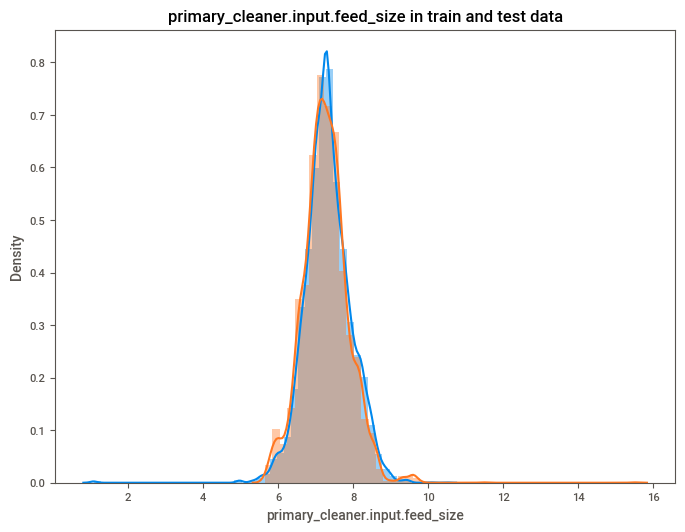

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(data_train['primary_cleaner.input.feed_size'],label='feed_size in train')
sns.distplot(data_test['primary_cleaner.input.feed_size'],label='feed_size in test')
plt.title('primary_cleaner.input.feed_size in train and test data')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


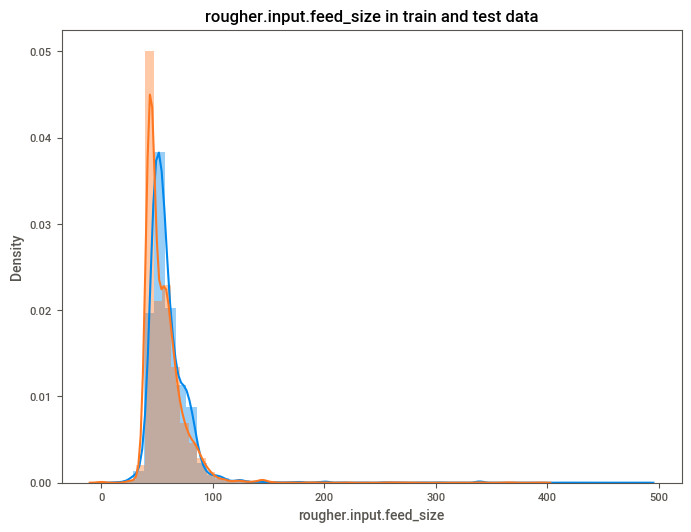

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(data_train['rougher.input.feed_size'],label='feed_size in train')
sns.distplot(data_test['rougher.input.feed_size'],label='feed_size in test')
plt.title('rougher.input.feed_size in train and test data')
plt.show()

Из графика видно, что распределение в обучающей выборке очень близко к распределению в тестовой.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [ ]:
final_concentrate = data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_au'] + \
    data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']

primary_concentrate = data_full['primary_cleaner.output.concentrate_ag'] + data_full['primary_cleaner.output.concentrate_au'] \
    + data_full['primary_cleaner.output.concentrate_pb'] + data_full['primary_cleaner.output.concentrate_sol']

rougher_concentrate = data_full['rougher.output.concentrate_ag'] + data_full['rougher.output.concentrate_au'] + \
    data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']

In [ ]:
data_sum = {'rougher_concentrate': rougher_concentrate, 'primary_concentrate' : primary_concentrate, 'final_concentrate' : final_concentrate}
pd.DataFrame(data=data_sum)

,rougher_concentrate,primary_concentrate,final_concentrate
0,66.424950,72.640924,63.644396
1,67.012710,72.543485,63.957723
2,66.103793,72.095042,64.311180
3,65.752751,59.957723,63.573449
4,65.908382,71.321010,64.004667
...,...,...,...
19434,70.781325,59.001692,68.098589
19435,70.539603,59.703912,68.274362
19436,55.376330,59.561096,68.226068
19437,69.201689,57.216686,68.200449


[Text(0.5, 1.0, 'Суммарная концентрация веществ')]

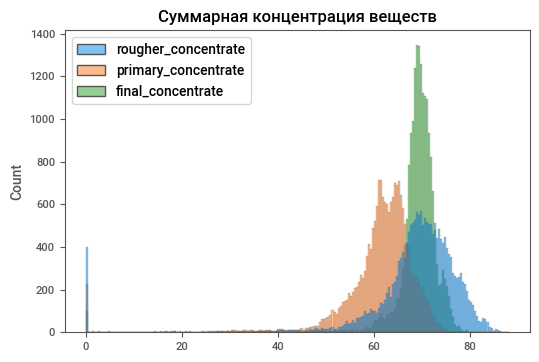

In [ ]:
ax = sns.histplot(data=data_sum)
ax.set(title='Суммарная концентрация веществ')

Суммарная концентрация больше всего именно на финальном этапе.

На графике заметно, что есть много нулевых значений на этапе флотации(394), и около 100 нулей на финальном этапе и первичной обработки. Удалим эти значения как аномалии. 

In [ ]:
def not_null(data, stage):
  data = data[(data[f'{stage}_au'] != 0) & (data[f'{stage}_ag'] != 0) & (data[f'{stage}_pb'] != 0) \
              & (data[f'{stage}_sol'] != 0)]
  return data

In [ ]:
data_train = not_null(data_train, 'rougher.output.concentrate')
data_train = not_null(data_train, 'final.output.concentrate')

data_full = not_null(data_full, 'rougher.output.concentrate')
data_full = not_null(data_full, 'final.output.concentrate')

data_train.shape, data_full.shape

((13792, 87), (18946, 87))

# Построим модель

## Напишем функцию для вычисления итоговой sMAPE

In [ ]:
def sMAPE(target, predict):
    smape = (1/(len(target))) * (sum( (abs(target - predict) / ((abs(target) + abs(predict))/ 2)) )* 100)
    return smape

In [ ]:
smape_scorer = make_scorer(sMAPE, greater_is_better = False)

Для итоговой метрики.

In [ ]:
def result_sMAPE(rougher, final):
    return 0.25 * rougher + 0.75 * final

## Обучим модели и оценим их качество кросс-валидацией

Выберем колонки для обучающей выборки те, что есть в тестовом наборе. Также удалим значение даты, так как оно не нужно для построении модели.

In [ ]:
data_test.drop(['date'], axis=1, inplace=True)
data_train.drop(['date'], axis=1, inplace=True)

Разделим данные на признаки.

In [ ]:
data_test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Запишем целевой признак для обучающей выборки и для тестовой.

In [ ]:
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']

In [ ]:
target_test_rougher = data_test['rougher.output.recovery']
target_test_final = data_test['final.output.recovery']

In [ ]:
column_test = data_test.columns
data_train = data_train[column_test]
data_train.shape, data_test.shape

((13792, 54), (5290, 54))

In [ ]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [ ]:
features_train.shape, features_test.shape, target_train_rougher.shape, target_train_final.shape, target_test_rougher.shape, target_test_final.shape

((13792, 52), (5290, 52), (13792,), (13792,), (5290,), (5290,))

Сохраним для каждой модели показатели sMAPE.

In [ ]:
scores = {}

### Линейная регрессия

Смотрим корреляцию признаков.

Корреляция с целевыми показателями.

In [ ]:
data_train.corr()[['rougher.output.recovery', 'final.output.recovery']]

,rougher.output.recovery,final.output.recovery
primary_cleaner.input.sulfate,0.432935,0.382883
primary_cleaner.input.depressant,0.131798,0.151901
primary_cleaner.input.feed_size,-0.045873,0.069457
primary_cleaner.input.xanthate,0.184713,0.212050
primary_cleaner.state.floatbank8_a_air,0.198466,0.151261
primary_cleaner.state.floatbank8_a_level,0.016862,0.031480
primary_cleaner.state.floatbank8_b_air,0.223643,0.168460
primary_cleaner.state.floatbank8_b_level,0.011262,0.044980
primary_cleaner.state.floatbank8_c_air,0.243407,0.157243
primary_cleaner.state.floatbank8_c_level,0.016497,0.026599


Разобьем по этапам обработки металлов и посмотрим корреляцию выше 0.8.

Список столбцов на удаление.

In [ ]:
list_corr = []

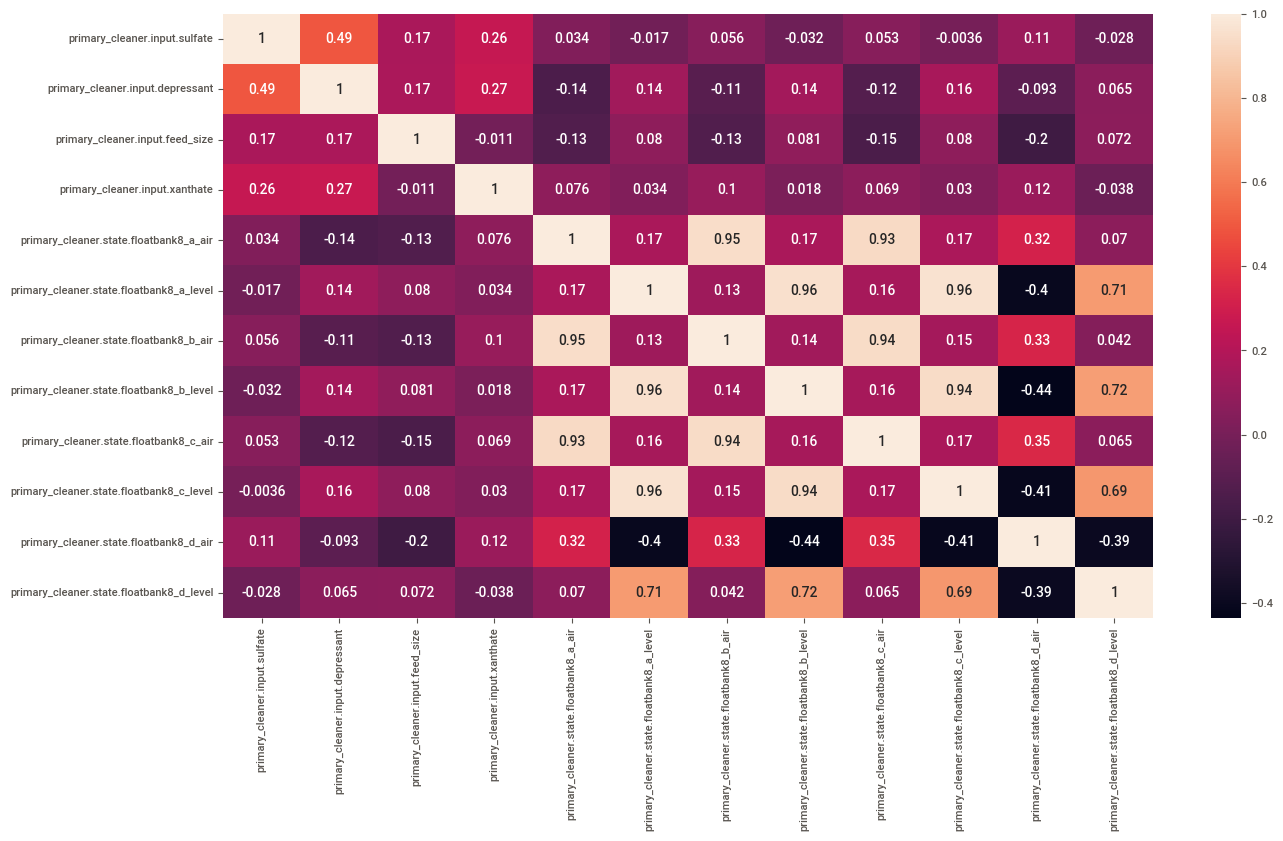

In [ ]:
primary_corr = data_train.filter(like='primary_cleaner')
plt.figure(figsize=(15,8))
sns.heatmap(primary_corr.corr(), annot=True)

Добавим сильно коррелирующие признаки, посмотрим зависимость с целевым, уберем те, что сильнее коррелируют с целевыми.

In [ ]:
list_corr.extend(['primary_cleaner.state.floatbank8_b_air', \
                 'primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_air',\
                'primary_cleaner.state.floatbank8_a_level'])

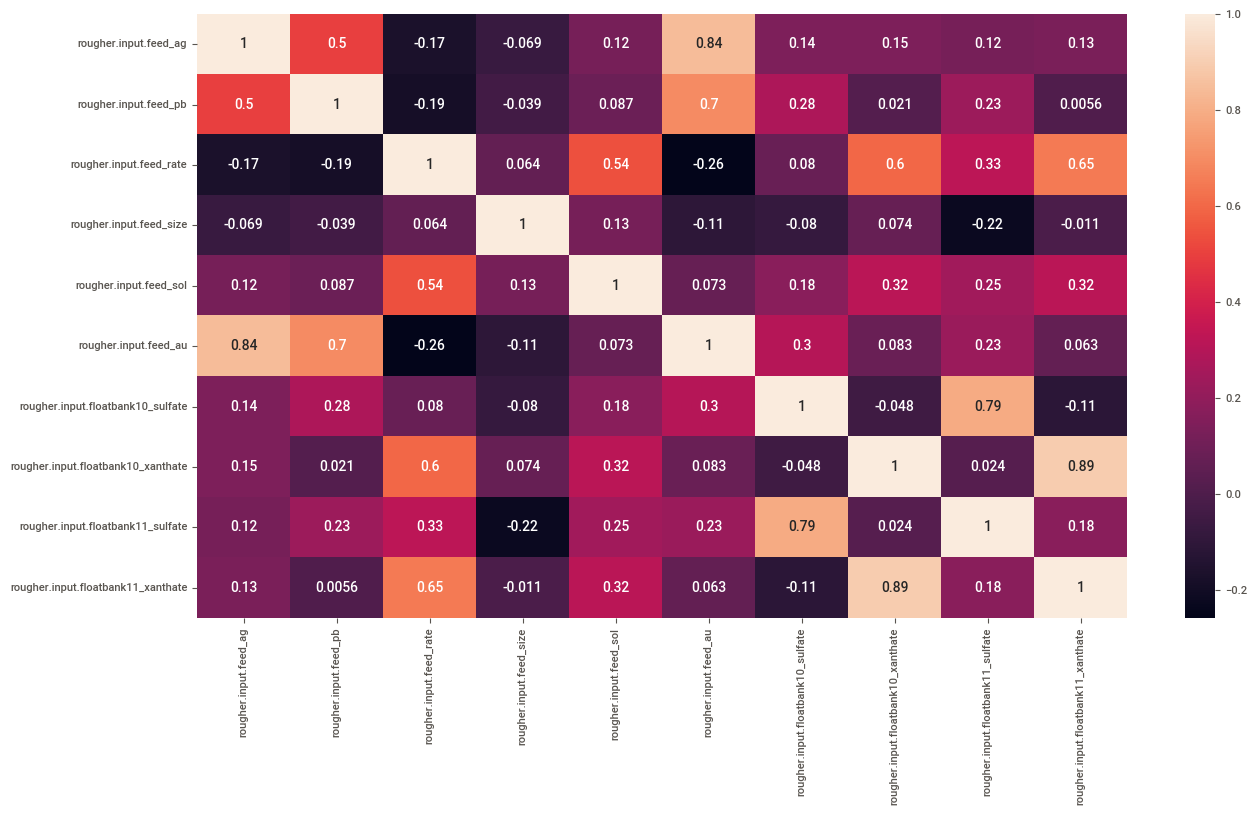

In [ ]:
rougher_corr = data_train.filter(like='rougher.input')
plt.figure(figsize=(15,8))
sns.heatmap(rougher_corr.corr(), annot=True)

In [ ]:
list_corr.extend(['rougher.input.feed_ag', 'rougher.input.floatbank10_xanthate'])

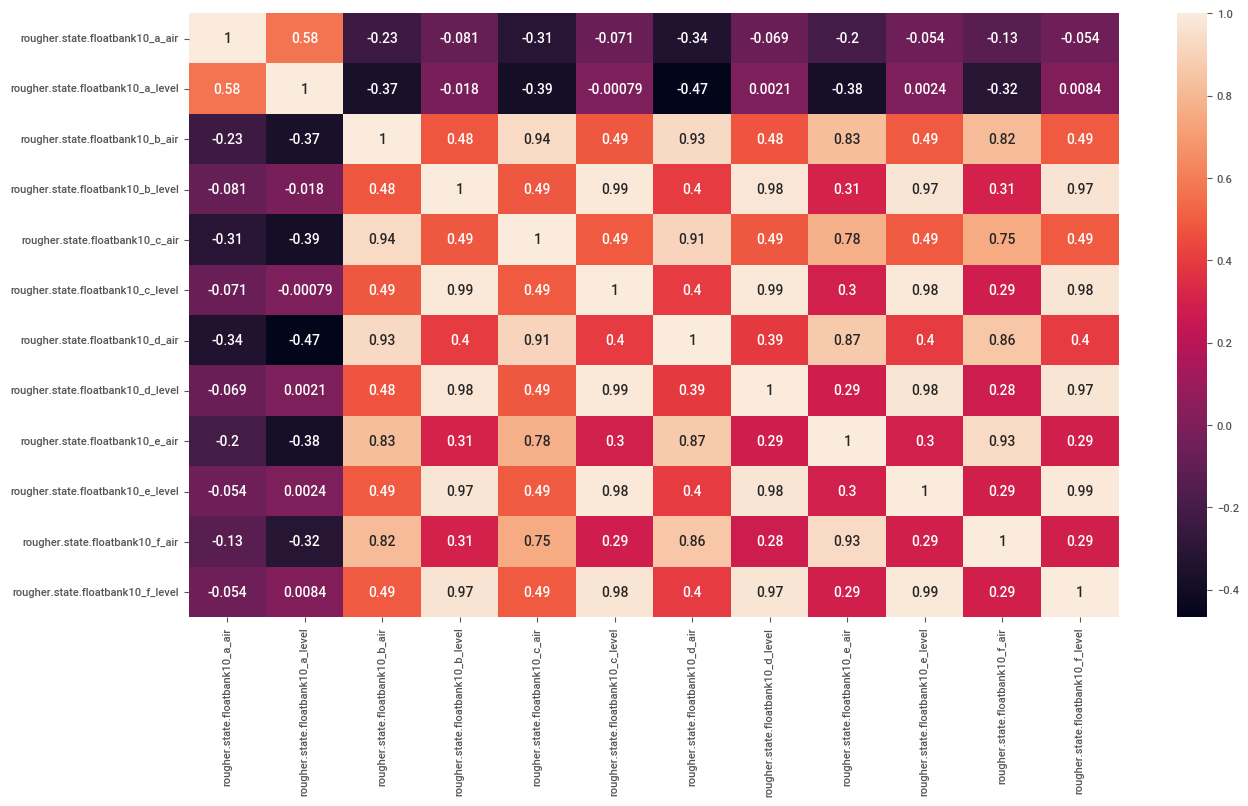

In [ ]:
rougher_state_corr = data_train.filter(like='rougher.state')
plt.figure(figsize=(15,8))
sns.heatmap(rougher_state_corr.corr(), annot=True)

Здесь корреляция очень сильная, возьмем порог 0.9. 

In [ ]:
list_corr.extend(['rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_f_air',\
                  'rougher.state.floatbank10_c_air','rougher.state.floatbank10_c_level'])

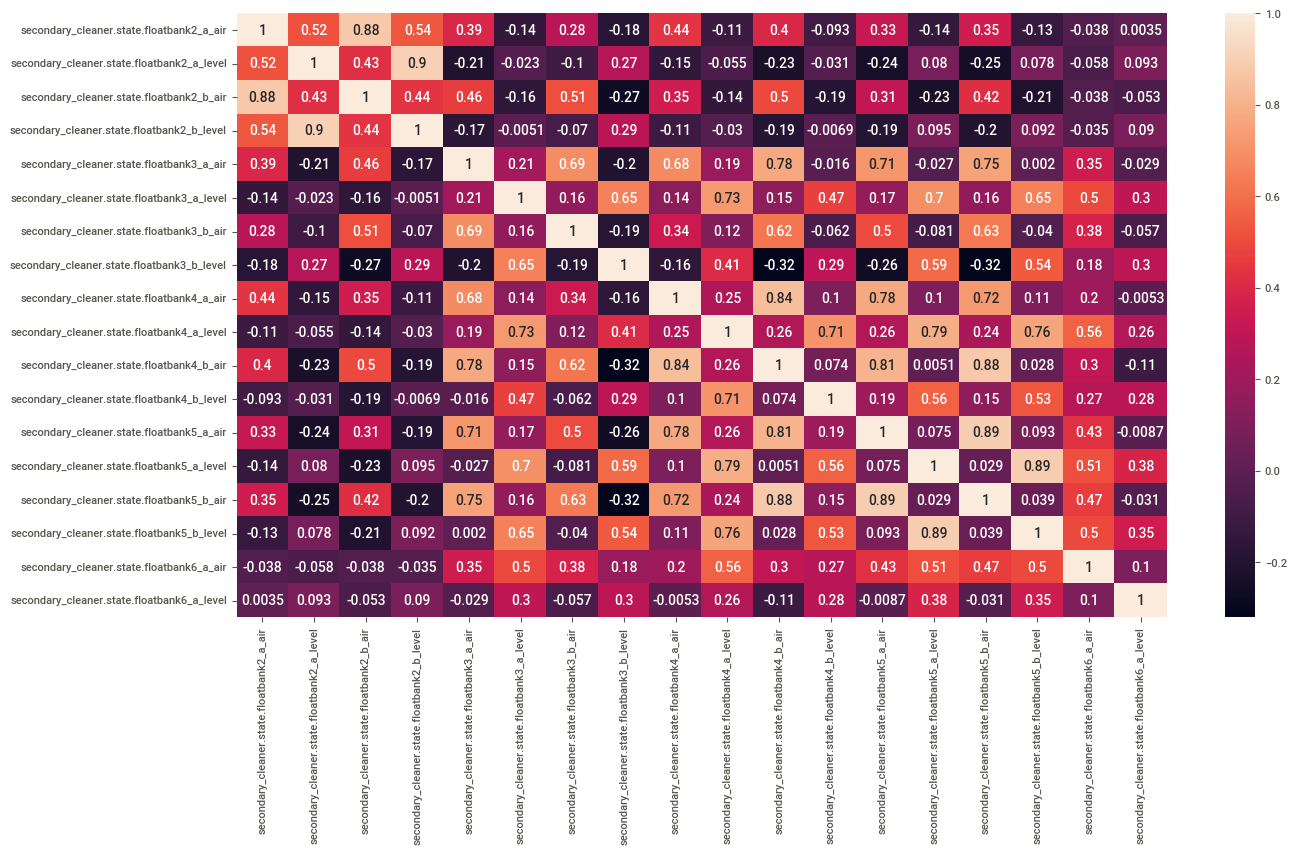

In [ ]:
secondary_corr = data_train.filter(like='secondary_cleaner.state')
plt.figure(figsize=(15,8))
sns.heatmap(secondary_corr.corr(), annot=True)

In [ ]:
list_corr.extend(['secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',\
                  'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_level', \
                  'secondary_cleaner.state.floatbank5_b_air'])

Удалим сильно коррелируещие столбцы.

In [ ]:
features_train.shape

(13792, 52)

In [ ]:
features_train_lin = features_train.drop(list_corr, axis=1)
features_train_lin.shape

(13792, 37)

In [ ]:
features_test_lin = features_test.drop(list_corr, axis=1)
features_test_lin.shape

(5290, 37)

Масштабируем данные.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_lin)
features_train_lin = scaler.transform(features_train_lin)
features_test_lin = scaler.transform(features_test_lin)

In [ ]:
lin_rougher = LinearRegression() # считаем для чернового концентрата
scores_rougher = cross_val_score(lin_rougher, features_train_lin, target_train_rougher, scoring=smape_scorer, cv=5)
outcome_rougher = sum(scores_rougher) / len(scores_rougher)

lin_final = LinearRegression() # считаем для финального концентрата
scores_final = cross_val_score(lin_final, features_train_lin, target_train_final, scoring=smape_scorer, cv=5)
outcome_final = sum(scores_final) / len(scores_final)

# считаем итоговую оценку

scores = {'LR' : result_sMAPE(outcome_rougher, outcome_final)*(-1)}
scores

{'LR': 9.501422591606225}

### Дерево решений

In [ ]:
state = np.random.RandomState(12345)

In [ ]:
model_tree = None # будет здесь лучшая модель дерева
best_result = 100

for depth in range(1, 10):
  #считаем для rougher
  tree_rougher = DecisionTreeRegressor(random_state=state, max_depth=depth)
  scores_rougher = cross_val_score(tree_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=5)
  outcome_rougher = sum(scores_rougher) / len(scores_rougher)

  # считаем для финальной
  tree_final = DecisionTreeRegressor(random_state=state, max_depth=depth)
  scores_final = cross_val_score(tree_final, features_train, target_train_final, scoring=smape_scorer, cv=5)
  outcome_final = sum(scores_final) / len(scores_final) 

  result = result_sMAPE(outcome_rougher, outcome_final)*(-1)
  if result < best_result:
    model_tree = tree_rougher
    best_result = result
    depth_best = depth    

# сохраниним оценку лучшей модели
scores['DR'] = best_result
print('sMAPE:', best_result)
print('Глубина дерева для лучшей модели:', depth_best)

sMAPE: 8.925785452030954
Глубина дерева для лучшей модели: 3


### Случайный лес

In [ ]:
best_model_rf = 100
for est in tqdm(range(300, 401, 100)):
  rf_rougher = RandomForestRegressor(n_estimators=est, max_depth=8, random_state=state)
  scores_rougher = cross_val_score(rf_rougher,
                                  features_train,
                                  target_train_rougher,
                                  scoring=smape_scorer,
                                  cv=5)
  outcome_rougher = sum(scores_rougher) / len(scores_rougher)

  rf_final = RandomForestRegressor(n_estimators=est, max_depth=8, random_state=state)
  smape_final = cross_val_score(rf_final,
                                features_train,
                                target_train_final,
                                scoring=smape_scorer,
                                cv=5)
  outcome_final = sum(smape_final) / len(smape_final)
  result = result_sMAPE(outcome_rougher, outcome_final)*(-1)
  if result < best_model_rf:
    best_model_rf = result

scores['FR'] = best_model_rf

print('sMAPE:', best_model_rf)
print(f'Количество деревьев в лесу {est}')

100%|██████████| 2/2 [34:13<00:00, 1026.78s/it]

sMAPE: 8.903745624669382
Количество деревьев в лесу 400


In [ ]:
scores

{'LR': 9.501422591606225, 'DR': 8.925785452030954, 'FR': 8.903745624669382}

**Итак,** лучшая модель - Случайный лес.

### Проверим на тестовой выборке

In [ ]:
# модель и предсказания для rougher
rf_test_rougher = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=state)
rf_test_rougher.fit(features_train, target_train_rougher)
predict_rougher = rf_test_rougher.predict(features_test)

# модель и предсказания для final
rf_test_final = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=state)
rf_test_final.fit(features_train, target_train_final)
predict_final = rf_test_final.predict(features_test)

# метрика sMAPE для каждого этапа и финальная
smape_test_rougher = sMAPE(target_test_rougher, predict_rougher)
smape_test_final = sMAPE(target_test_final, predict_final)

final = result_sMAPE(smape_test_rougher, smape_test_final)

In [ ]:
print(f'SMAPE для тестовой выборки - {final}')

SMAPE для тестовой выборки - 9.24981766640334


# Вывод

Задачей было спрогнозировать эффективность обогащения чернового и финального концентрата. В наших данный были расчеты эффективности, для проверки точности этих значений мы посчитали по формуле, и различия минимальны.  
Имеем, что 75% значений эффективности находятся выше 79.9%.  

Мы наглядно проверили, что распределение размеров гранул в тестовой выборке и обучающей совпадает. Это необходимо для верной оценки модели.  

Изучили концентрацию веществ на разных стадиях. Концентрация золота растет на каждом этапе, а после флотации сильнее всего. Серебро выше всего на начальных этапах, затем падает. Концентрация свинца сначала растет, затем держится примерно на одном уровне.  

Построили три регрессионные модели - Линейную, Дерево решений, Случайный лес. Оценили качество с помощью метрики sMAPE - симметрическое среднее абсолютное процентное отклонение. Лучшие показатели у Случайного леса. Протестировали модель на тестовой выборки и получили отклонение 9.24%, довольно низкий показатель, предсказания модели достаточно точные.